In [33]:
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from plotly.offline import plot, iplot, init_notebook_mode

In [34]:
n_estimators = 100
max_depth = 5
gamma = 0
learning_rate = 0.1            
min_child_weight = 2           
subsample = 0.9                 
colsample_bytree = 1.0          
colsample_bylevel = 0.9        

In [35]:
data=pd.read_csv('dataset.csv')
data = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})

In [36]:
# data['open'] = data['open'].astype(float)
# data['close'] = data['close'].astype(float)
# data['high'] = data['high'].astype(float)
# data['low'] = data['low'].astype(float)
# data['volume'] = data['volume'].astype(float)

In [37]:
data.tail()

,date,open,high,low,close,adj_close,volume
1457,28/12/2021,50679.85938,50679.85938,47414.21094,47588.85547,47588.85547,3.343038e+10
1458,29/12/2021,47623.87109,48119.74219,46201.49609,46444.71094,46444.71094,3.004923e+10
1459,30/12/2021,46490.60547,47879.96484,46060.31250,47178.12500,47178.12500,2.668649e+10
1460,31/12/2021,47169.37109,48472.52734,45819.95313,46306.44531,46306.44531,3.697417e+10
1461,01/01/2022,46311.74609,47827.31250,46288.48438,47686.81250,47686.81250,2.458267e+10


In [38]:
data.shape

(1462, 7)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1462 non-null   object 
 1   open       1462 non-null   float64
 2   high       1462 non-null   float64
 3   low        1462 non-null   float64
 4   close      1462 non-null   float64
 5   adj_close  1462 non-null   float64
 6   volume     1462 non-null   float64
dtypes: float64(6), object(1)
memory usage: 80.1+ KB


In [40]:
data.isna().any()

date         False
open         False
high         False
low          False
close        False
adj_close    False
volume       False
dtype: bool

In [41]:
data['date'] = pd.to_datetime(data.date, format='%d/%m/%Y')
data.head()

,date,open,high,low,close,adj_close,volume
0,2018-01-01,14112.2002,14112.20020,13154.70020,13657.20020,13657.20020,1.029120e+10
1,2018-01-02,13625.0000,15444.59961,13163.59961,14982.09961,14982.09961,1.684660e+10
2,2018-01-03,14978.2002,15572.79981,14844.50000,15201.00000,15201.00000,1.687190e+10
3,2018-01-04,15270.7002,15739.70020,14522.20020,15599.20020,15599.20020,2.178320e+10
4,2018-01-05,15477.2002,17705.19922,15202.79981,17429.50000,17429.50000,2.384090e+10


In [42]:
data['range_high_low'] = data['high'] - data['low']
data.drop(['adj_close'], axis=1, inplace=True)
data.drop(['high', 'low'], axis=1, inplace=True)
data['range_open_close'] = data['open'] - data['close']
data.drop(['open'], axis=1, inplace=True)
data_modified = data.copy()
price_df = data['close']

In [43]:
data_modified

,date,close,volume,range_high_low,range_open_close
0,2018-01-01,13657.20020,1.029120e+10,957.50000,455.00000
1,2018-01-02,14982.09961,1.684660e+10,2281.00000,-1357.09961
2,2018-01-03,15201.00000,1.687190e+10,728.29981,-222.79980
3,2018-01-04,15599.20020,2.178320e+10,1217.50000,-328.50000
4,2018-01-05,17429.50000,2.384090e+10,2502.39941,-1952.29980
...,...,...,...,...,...
1457,2021-12-28,47588.85547,3.343038e+10,3265.64844,3091.00391
1458,2021-12-29,46444.71094,3.004923e+10,1918.24610,1179.16015
1459,2021-12-30,47178.12500,2.668649e+10,1819.65234,-687.51953
1460,2021-12-31,46306.44531,3.697417e+10,2652.57421,862.92578


In [44]:
date = data["date"]
date
date = np.array(date)
date

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', ...,
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [45]:
print("Starting date: ",data.iloc[0][0])
print("Ending date: ", data.iloc[-1][0])
print("Duration: ", data.iloc[-1][0]-data.iloc[0][0])

Starting date:  2018-01-01 00:00:00
Ending date:  2022-01-01 00:00:00
Duration:  1461 days 00:00:00


In [46]:
data_modified.shape

(1462, 5)

In [47]:
df = data_modified.copy()
print("Total data for prediction: ",df.shape[0])

Total data for prediction:  1462


In [48]:
# gold_price = pd.read_csv('gold_price.csv')
# gold_price['date'] = pd.to_datetime(gold_price.date, format='%d/%m/%Y')
# gold_price = gold_price.rename(columns={'date': 'date','close':'gold_close'})

# df_result = pd.merge(df, gold_price, on='date',how = 'left')
# df_result.fillna(method = 'ffill',inplace=True)
# df_result["gold_close"] = np.log(df_result['gold_close'] / df_result['gold_close'].shift(1))
# df_result = df_result[1:]
# date = df_result["date"]
# df = df_result

In [49]:
# add ETH price
etheruem_price = pd.read_csv('ETH.csv')
etheruem_price = etheruem_price.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'etheruem_close',
                                'Adj Close':'adj_close','Volume':'etheruem_volume'})
etheruem_price['date'] = pd.to_datetime(etheruem_price.date, format='%d/%m/%Y')
etheruem_price['etheruem_close'] = np.log(etheruem_price['etheruem_close'] / etheruem_price['etheruem_close'].shift(1))
etheruem_price = etheruem_price[['date','etheruem_close']]
etheruem_price


df_result = pd.merge(df, etheruem_price, on='date')
df = df_result[1:]

In [50]:
del df['date']

In [51]:
scaler=MinMaxScaler(feature_range=(0,1))
X=scaler.fit_transform(df)
data_scaled = pd.DataFrame(X, columns=df.columns,
                          index=df.index)

In [52]:
data_scaled

,close,volume,range_high_low,range_open_close,etheruem_close
1,0.182579,0.040000,0.176096,0.400207,0.877723
2,0.185982,0.040072,0.055223,0.476470,0.813301
3,0.192172,0.054182,0.093306,0.469363,0.728746
4,0.220624,0.060094,0.193331,0.360190,0.726506
5,0.222139,0.044217,0.072310,0.487086,0.759955
...,...,...,...,...,...
1457,0.689446,0.087644,0.252748,0.699267,0.627481
1458,0.671660,0.077930,0.147857,0.570728,0.645388
1459,0.683061,0.068269,0.140182,0.445225,0.734519
1460,0.669511,0.097825,0.205022,0.549466,0.693974


In [53]:
N = 2
data_processed = data_scaled.copy()
for i in range(1,N+1):
    data_shifted = data_scaled.shift(i)
    
    data_shifted = data_shifted.rename(columns={'close': 'close_lag'+str(i),'volume':'volume_lag'+str(i),'range_high_low':'range_high_low_lag'+str(i),
                                         'range_open_close':'range_open_close_lag'+str(i),
                                                'gold_close':'gold_close_lag'+str(i),'etheruem_close':'etheruem_close_lag'+str(i),
                                               'etheruem_volume':'etheruem_volume_lag'+str(i)})
    data_processed = pd.concat([data_processed,data_shifted],axis=1)
data_processed

,close,volume,range_high_low,range_open_close,etheruem_close,close_lag1,volume_lag1,range_high_low_lag1,range_open_close_lag1,etheruem_close_lag1,close_lag2,volume_lag2,range_high_low_lag2,range_open_close_lag2,etheruem_close_lag2
1,0.182579,0.040000,0.176096,0.400207,0.877723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.185982,0.040072,0.055223,0.476470,0.813301,0.182579,0.040000,0.176096,0.400207,0.877723,NaN,NaN,NaN,NaN,NaN
3,0.192172,0.054182,0.093306,0.469363,0.728746,0.185982,0.040072,0.055223,0.476470,0.813301,0.182579,0.040000,0.176096,0.400207,0.877723
4,0.220624,0.060094,0.193331,0.360190,0.726506,0.192172,0.054182,0.093306,0.469363,0.728746,0.185982,0.040072,0.055223,0.476470,0.813301
5,0.222139,0.044217,0.072310,0.487086,0.759955,0.220624,0.060094,0.193331,0.360190,0.726506,0.192172,0.054182,0.093306,0.469363,0.728746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,0.689446,0.087644,0.252748,0.699267,0.627481,0.736882,0.061483,0.111939,0.502354,0.695373,0.739510,0.051830,0.121002,0.465845,0.696637
1458,0.671660,0.077930,0.147857,0.570728,0.645388,0.689446,0.087644,0.252748,0.699267,0.627481,0.736882,0.061483,0.111939,0.502354,0.695373
1459,0.683061,0.068269,0.140182,0.445225,0.734519,0.671660,0.077930,0.147857,0.570728,0.645388,0.689446,0.087644,0.252748,0.699267,0.627481
1460,0.669511,0.097825,0.205022,0.549466,0.693974,0.683061,0.068269,0.140182,0.445225,0.734519,0.671660,0.077930,0.147857,0.570728,0.645388


In [54]:
data_processed = data_processed[N:]
data_processed

,close,volume,range_high_low,range_open_close,etheruem_close,close_lag1,volume_lag1,range_high_low_lag1,range_open_close_lag1,etheruem_close_lag1,close_lag2,volume_lag2,range_high_low_lag2,range_open_close_lag2,etheruem_close_lag2
3,0.192172,0.054182,0.093306,0.469363,0.728746,0.185982,0.040072,0.055223,0.476470,0.813301,0.182579,0.040000,0.176096,0.400207,0.877723
4,0.220624,0.060094,0.193331,0.360190,0.726506,0.192172,0.054182,0.093306,0.469363,0.728746,0.185982,0.040072,0.055223,0.476470,0.813301
5,0.222139,0.044217,0.072310,0.487086,0.759955,0.220624,0.060094,0.193331,0.360190,0.726506,0.192172,0.054182,0.093306,0.469363,0.728746
6,0.205827,0.037182,0.114667,0.562024,0.834898,0.222139,0.044217,0.072310,0.487086,0.759955,0.220624,0.060094,0.193331,0.360190,0.726506
7,0.185502,0.044502,0.179887,0.579262,0.699617,0.205827,0.037182,0.114667,0.562024,0.834898,0.222139,0.044217,0.072310,0.487086,0.759955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,0.689446,0.087644,0.252748,0.699267,0.627481,0.736882,0.061483,0.111939,0.502354,0.695373,0.739510,0.051830,0.121002,0.465845,0.696637
1458,0.671660,0.077930,0.147857,0.570728,0.645388,0.689446,0.087644,0.252748,0.699267,0.627481,0.736882,0.061483,0.111939,0.502354,0.695373
1459,0.683061,0.068269,0.140182,0.445225,0.734519,0.671660,0.077930,0.147857,0.570728,0.645388,0.689446,0.087644,0.252748,0.699267,0.627481
1460,0.669511,0.097825,0.205022,0.549466,0.693974,0.683061,0.068269,0.140182,0.445225,0.734519,0.671660,0.077930,0.147857,0.570728,0.645388


In [55]:
# data_processed.to_csv("ETH_processed.csv",index=False)

In [56]:
labels = data_processed['close']
labels
features = data_processed.copy()
features.drop(['close', 'volume','range_high_low','range_open_close'], axis=1, inplace=True)
features

,etheruem_close,close_lag1,volume_lag1,range_high_low_lag1,range_open_close_lag1,etheruem_close_lag1,close_lag2,volume_lag2,range_high_low_lag2,range_open_close_lag2,etheruem_close_lag2
3,0.728746,0.185982,0.040072,0.055223,0.476470,0.813301,0.182579,0.040000,0.176096,0.400207,0.877723
4,0.726506,0.192172,0.054182,0.093306,0.469363,0.728746,0.185982,0.040072,0.055223,0.476470,0.813301
5,0.759955,0.220624,0.060094,0.193331,0.360190,0.726506,0.192172,0.054182,0.093306,0.469363,0.728746
6,0.834898,0.222139,0.044217,0.072310,0.487086,0.759955,0.220624,0.060094,0.193331,0.360190,0.726506
7,0.699617,0.205827,0.037182,0.114667,0.562024,0.834898,0.222139,0.044217,0.072310,0.487086,0.759955
...,...,...,...,...,...,...,...,...,...,...,...
1457,0.627481,0.736882,0.061483,0.111939,0.502354,0.695373,0.739510,0.051830,0.121002,0.465845,0.696637
1458,0.645388,0.689446,0.087644,0.252748,0.699267,0.627481,0.736882,0.061483,0.111939,0.502354,0.695373
1459,0.734519,0.671660,0.077930,0.147857,0.570728,0.645388,0.689446,0.087644,0.252748,0.699267,0.627481
1460,0.693974,0.683061,0.068269,0.140182,0.445225,0.734519,0.671660,0.077930,0.147857,0.570728,0.645388


In [57]:
labels

3       0.192172
4       0.220624
5       0.222139
6       0.205827
7       0.185502
          ...   
1457    0.689446
1458    0.671660
1459    0.683061
1460    0.669511
1461    0.690969
Name: close, Length: 1459, dtype: float64

In [58]:
def create_dataset(features, labels, test_prop = 0.15):
    train_size=int(len(features)*(1-test_prop))
    X_train = features[:train_size]
    Y_train = labels[:train_size]
    X_test = features[train_size:]
    Y_test = labels[train_size:]
    return np.array(X_train), np.array(Y_train),np.array(X_test),np.array(Y_test),train_size

In [59]:
X_train,Y_train,X_test,Y_test, train_size = create_dataset(features,labels,0.15)
print("X_train: ", X_train.shape)
print("y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test", Y_test.shape)

X_train:  (1240, 11)
y_train:  (1240,)
X_test:  (219, 11)
Y_test (219,)


In [60]:
my_model = XGBRegressor(n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight,
                    colsample_bylevel=colsample_bylevel,
                    colsample_bytree=colsample_bytree,
                       gamma=gamma,
                       subsample=subsample)
my_model.fit(X_train, Y_train)
predictions = my_model.predict(X_test)
print("Mean Absolute Percentage Error - MAPE : " + str(mean_absolute_percentage_error(Y_test, predictions)*100)+"%")
# print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(Y_test, predictions))))

Mean Absolute Percentage Error - MAPE : 2.7927882233029373%
Root Mean squared Error - RMSE : 0.025861477633604437


In [61]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1240, 1)
Test data prediction: (219, 1)


In [62]:
scaler1=MinMaxScaler(feature_range=(0,1))
Y=scaler1.fit_transform(np.array(price_df).reshape(-1,1))
# data_price = pd.DataFrame(Y, columns=price_df.columns,
#                           index=price_df.index)
train_predict = scaler1.inverse_transform(train_predict)
test_predict = scaler1.inverse_transform(test_predict)
original_ytrain = scaler1.inverse_transform(Y_train.reshape(-1,1)) 
original_ytest = scaler1.inverse_transform(Y_test.reshape(-1,1)) 

In [63]:
print("Mean Absolute Percentage Error - MAPE : " + str(mean_absolute_percentage_error(original_ytest, test_predict)*100)+"%")

# print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(original_ytest, test_predict))))
print("R2 : " + str(r2_score(original_ytest, test_predict)))

Mean Absolute Percentage Error - MAPE : 2.5926499813257498%
Root Mean squared Error - RMSE : 1663.670553135899
R2 : 0.9712563962045371


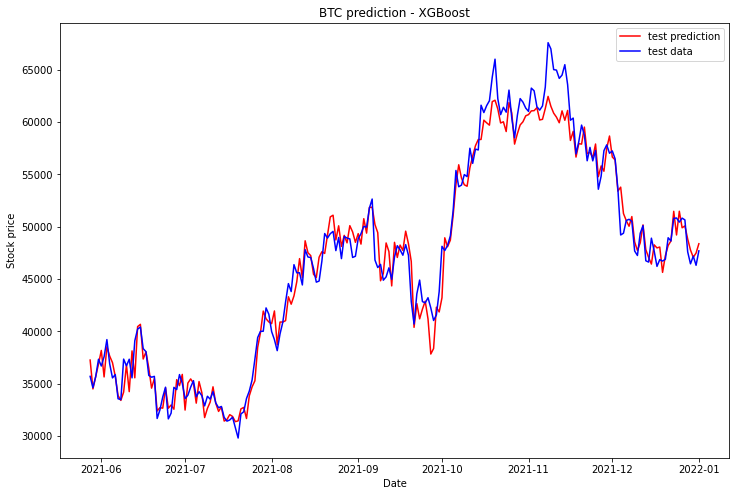

In [65]:
plt.figure(figsize=[12,8])
plt.plot(date[3+train_size:],test_predict,color="red", label = "test prediction")
plt.plot(date[3+train_size:],original_ytest, color = "blue",label = "test data")
# plt.plot(date[2:-219],original_ytrain, color = "green")
plt.title("BTC prediction - XGBoost")
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend()
plt.show()